In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
from evallm.enumerate_dfa.enumerate import unpack_dfa
from evallm.experiments.exhaustive_transducer_experiment import (
    exhaustive_gpt_4o_mini,
    exhaustive_llama,
)
from evallm.experiments.exhaustive_transducer_analysis import (
    compute_all_summary_stats,
    plot_comparison,
)
from evallm.experiments.render_dfa import render_pdfas

In [4]:
summaries = {}
for model, func in [
    ("gpt-4o-mini", exhaustive_gpt_4o_mini),
    ("llama-3-8b", exhaustive_llama),
]:
    summaries[model] = {k: v[0] for k, v in func(1).items() if v[0] is not None}

In [5]:
pdfas, ngram, no_nan, nan_bad = compute_all_summary_stats(summaries)

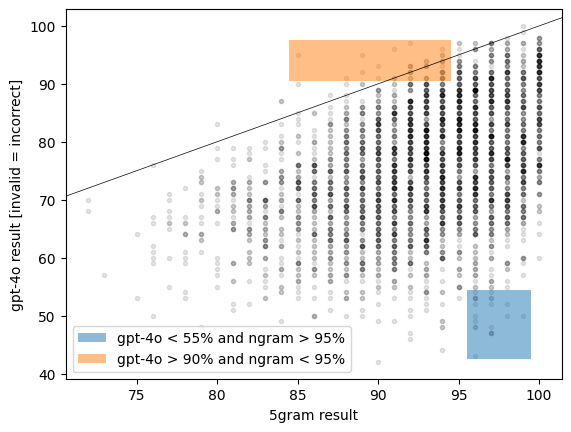

In [6]:
masks = plot_comparison(
    ngram,
    nan_bad["gpt-4o-mini"],
    "5gram result",
    "gpt-4o result [invalid = incorrect]",
    {
        "gpt-4o < 55% and ngram > 95%": lambda x, y: (x > 95) & (y < 55),
        "gpt-4o > 90% and ngram < 95%": lambda x, y: (x < 95) & (y > 90),
    },
)

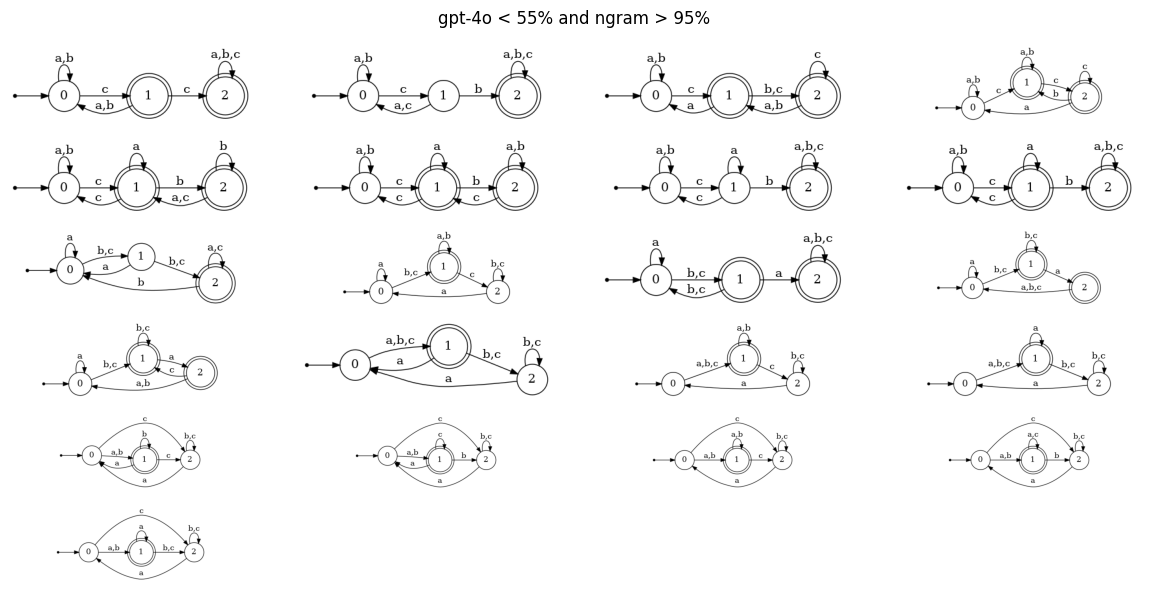

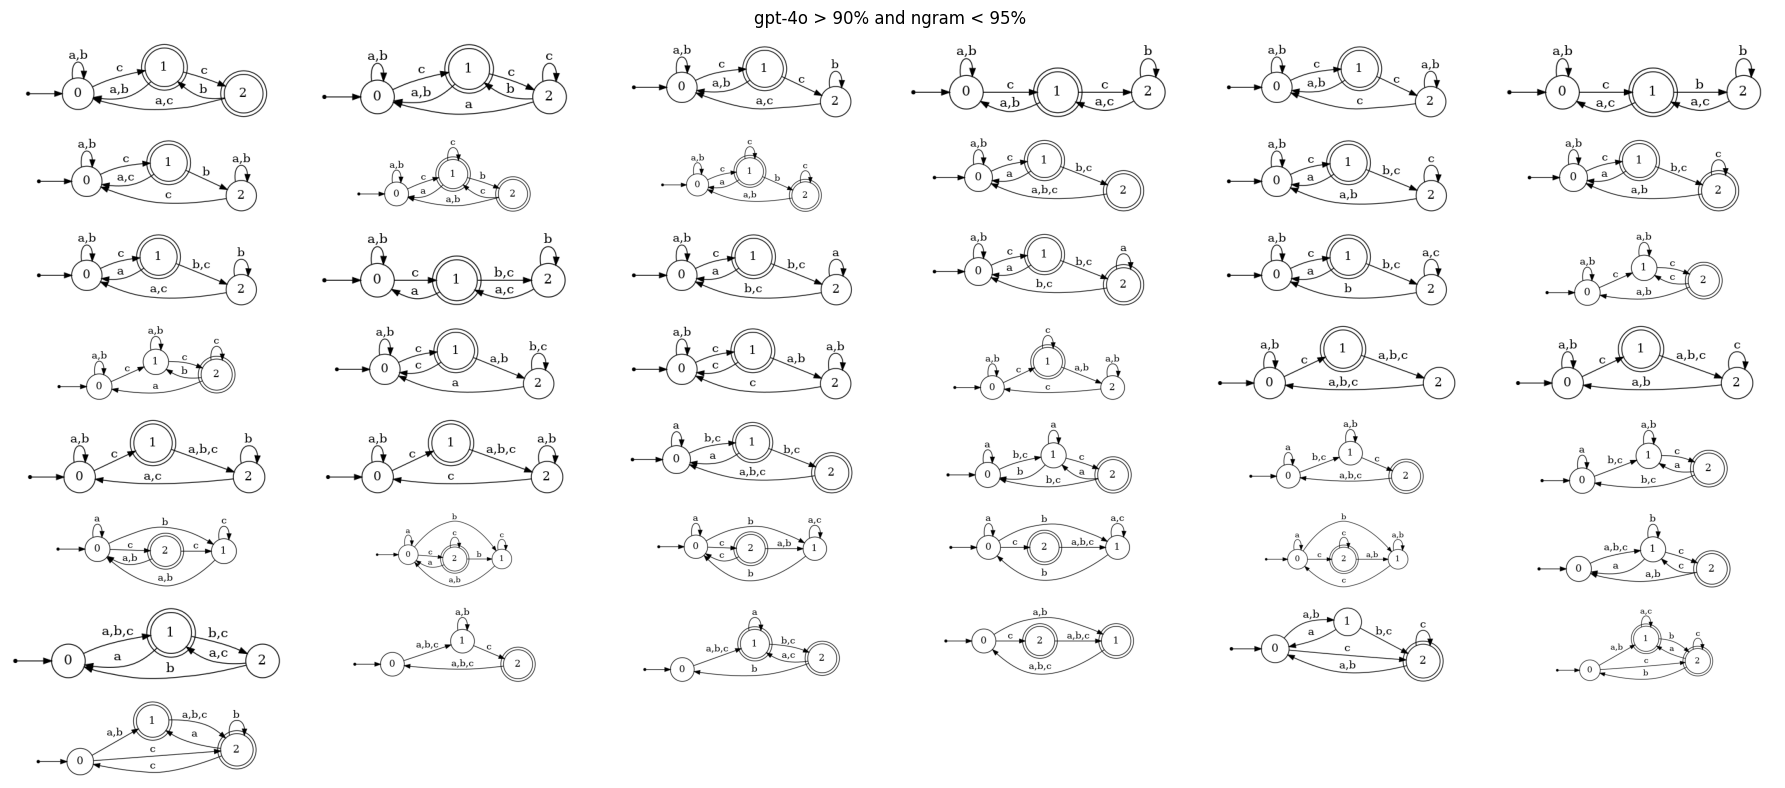

In [7]:
for label in masks:
    render_pdfas([pdfas[i] for i in np.where(masks[label])[0]], label)
    plt.show()

/mnt/md0/evallm/evallm/experiments/exhaustive_transducer_analysis.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


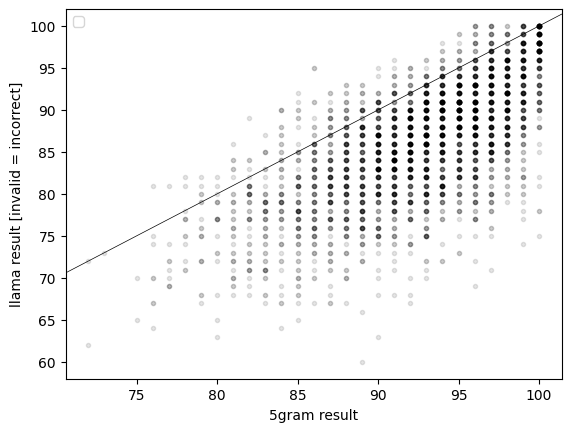

In [8]:
_ = plot_comparison(
    ngram,
    nan_bad["llama-3-8b"],
    "5gram result",
    "llama result [invalid = incorrect]",
    {},
)

In [9]:
# import tqdm.auto as tqdm
# from collections import Counter
# from evallm.sample_dfa.sample_dfa import sample_dfa
# from evallm.enumerate_dfa.pack_dfa import pack_dfa


# def distribution_of_dfas(count):
#     return Counter(
#         pack_dfa(
#             sample_dfa(
#                 dict(type="sample_reachable_dfa", n_states=3, n_symbols=3),
#                 np.random.RandomState(i),
#             )
#         )
#         for i in tqdm.trange(count)
#     )

In [10]:
# c = distribution_of_dfas(10_000)

In [11]:
# distro = np.array([c[pdfa] for pdfa in pdfas])

/mnt/md0/evallm/evallm/experiments/exhaustive_transducer_analysis.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


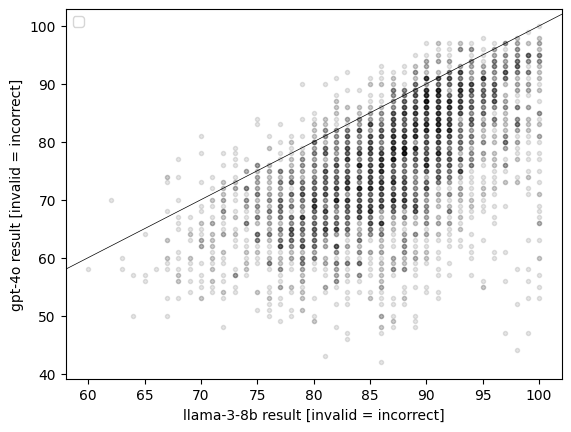

In [12]:
_ = plot_comparison(
    nan_bad["llama-3-8b"],
    nan_bad["gpt-4o-mini"],
    "llama-3-8b result [invalid = incorrect]",
    "gpt-4o result [invalid = incorrect]",
)

In [13]:
((nan_bad["llama-3-8b"] - nan_bad["gpt-4o-mini"]) ** 2).mean() ** 0.5

np.float64(13.79317025967033)

In [14]:
((nan_bad["llama-3-8b"] - ngram) ** 2).mean() ** 0.5

np.float64(8.058143123664502)

In [15]:
((nan_bad["gpt-4o-mini"] - ngram) ** 2).mean() ** 0.5

np.float64(19.645015759274024)